In [0]:
!pip install -U skater

In [0]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
%matplotlib inline

In [0]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00383/risk_factors_cervical_cancer.csv

In [4]:
# read in data
data = pd.read_csv('risk_factors_cervical_cancer.csv', na_values='?')
print('Shape: ', data.shape)
data.head()

Shape:  (858, 36)


,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
2,34,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,NaN,NaN,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0


In [5]:
# drop STD columns as it contains too many missing values
data_drop = data.drop(['STDs: Time since first diagnosis', 'STDs: Time since last diagnosis'], axis=1)
data_drop.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
2,34,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,0.0,0,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0


In [6]:
# drop extra data rows which contain missing observations
data_drop = data_drop.dropna()

print('Data shape: ', data_drop.shape)

# train test split
train_id = int(0.7*data_drop.shape[0])
idx = data_drop.index.values
np.random.seed(0)
np.random.shuffle(idx)
train = data_drop.loc[idx[:train_id],:]
test = data_drop.loc[idx[train_id:],:]
features_names = train.iloc[:,:-4].columns.tolist()
print('Train_Data shape: ', train.shape)
print('Test_Data shape: ', test.shape)
train.to_csv('train.csv')
test.to_csv('test.csv')

X_train = train.iloc[:,:-4].values
y_train = train.iloc[:,-4:].values
X_test = test.iloc[:,:-4].values
y_test = test.iloc[:,-4:].values
print ('X_train:', X_train.shape, '| y_train:', y_train.shape)
print ('X_test:', X_test.shape, '| y_test:', y_test.shape)

Data shape:  (668, 34)
Train_Data shape:  (467, 34)
Test_Data shape:  (201, 34)
X_train: (467, 30) | y_train: (467, 4)
X_test: (201, 30) | y_test: (201, 4)


In [0]:
col = 3
rf = RandomForestClassifier(n_estimators  = 100)
rf.fit(X_train, y_train[:,col])

2019-05-02 11:33:01,053 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[30/30] features ████████████████████ Time elapsed: 3 seconds

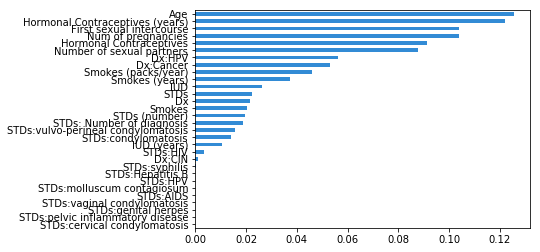

In [13]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

interpreter = Interpretation(X_test, feature_names=features_names)
model = InMemoryModel(rf.predict_proba, examples=X_train)
plots = interpreter.feature_importance.plot_feature_importance(model, ascending=True)


#### Use partial dependence to understand the relationship between a variable and a model's predictions

2019-05-02 11:32:51,652 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False
2019-05-02 11:32:51,656 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[29/29] grid cells ████████████████████ Time elapsed: 2 seconds

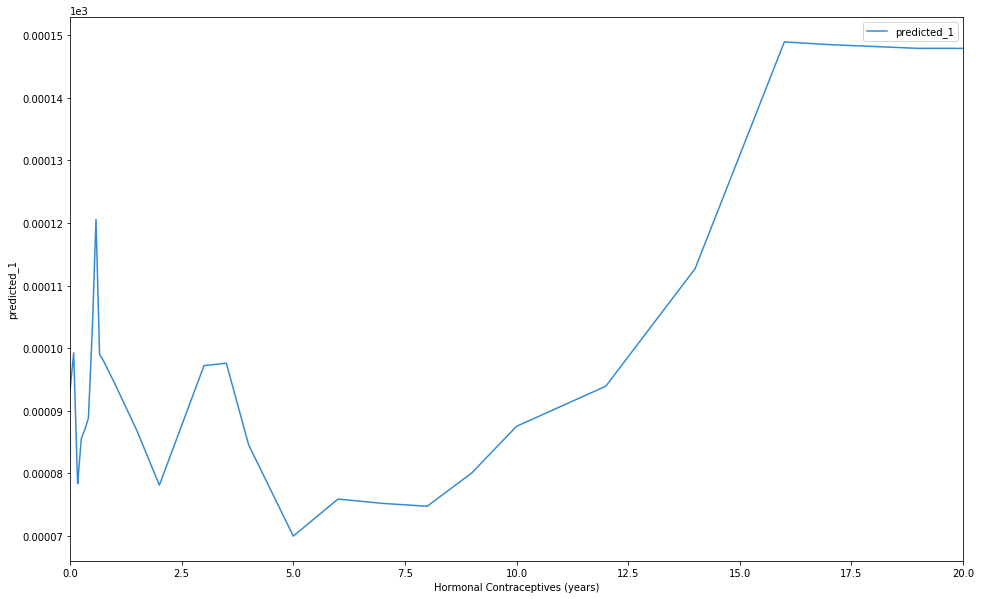

In [12]:
plots = interpreter.partial_dependence.plot_partial_dependence(['Hormonal Contraceptives (years)'], model, n_jobs=1)